# Binary Neural Networks

Existing deep neural networks use 32 bits, 16 bits or 8 bits to encode each weight and activation, making them large, slow and power-hungry. This prohibits many applications in resource-constrained environments.

Binary Neural Network is a type of neural network which activations (also called features) and weights are 1-bit values in all the hidden layers (except the input and output layers). In a few words, BNN is an extremely compacted case of CNN - it has the same structure except for different precision activations and weights. The use of BNNs enables not only significant reduction in memory usage, but also huge computational complexity improvements - the replacement of multiply-accumulation operations by `XNOR` and `bitcount` operations.

Today, we'll use `Larq` - an open-source Python library for training neural networks with extremely low-precision weights and activations.

You can find out more here: https://docs.larq.dev/larq/.

Larq is built on top of `TensorFlow` which is Python library for training neural networks, just like `PyTorch`. Because of that, we need to get familiar with this framework.

First, install and import necessary libraries.

In [1]:
# !pip install larq larq-zoo larq-compute-engine tensorflow

In [2]:
import tensorflow as tf
import larq as lq

We'll stick with simple 3-conv-layers CNN and MNIST dataset. This time, we'll implement it with `TensorFlow`.

First, we use `tf.keras.datasets.mnist.load_data()` to download a dataset. Then, we need to reshape images to `(numer_of_samples, image_width, image_height, number_of_channels)`. Finally, we normalize image values to be between -1 and 1.

In [3]:
import tensorflow as tf

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape images
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1


Now, we need to create our model. We'll use the same architecture as in `PyTorch`:

```
nn.Conv2d(input_channels,32,3,padding=(1,1))
nn.BatchNorm2d(32)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(32,64,3,padding=(1,1))
nn.BatchNorm2d(64)
nn.ReLU()
nn.MaxPool2d(2,2)

nn.Conv2d(64,128,3)
nn.BatchNorm2d(128)
nn.ReLU()

nn.Flatten(),
nn.Linear(CNN_out_size, num_of_cls),
nn.Softmax(dim=1)
```

In `TensorFlow` however, we define model with `tf.keras.models.Sequential()` and then we add layers one by one with `model.add()`.

Create model with the help of documentation (https://keras.io/api/layers/) and following tips. You're going to need following layers:

- In `PyTorch` we created convolutional layers with `Conv2d(in_ch, out_ch, kernel_size, padding=(x,x))`.  In `TrensorFlow` we use `tf.keras.layers.Conv2D(out_ch, kernel_size, strides=(x,x), padding="same")`.
- For `stride=(x,x)` and `padding="same"` we get the same result as with `padding=(x,x)` in PyTorch. We don't have to specify the number of input channels, but we have to specify `input_shape=(w,h,ch)` parameter for the first `Conv2D` layer.
- The activation function is not added as an additional layer, but as `activation="relu"` parameter to `Conv2D`.
- You'll need `tf.keras.layers.BatchNormalization(scale=False)`, `tf.keras.layers.MaxPooling2D((2, 2))`, `tf.keras.layers.Dense(output_size)` and `tf.keras.layers.Flatten()` layers.
- The last layer (softmax) in our model should be `tf.keras.layers.Activation("softmax")`.

In [4]:
# Define the model
CNN = tf.keras.models.Sequential()

# First convolutional layer
CNN.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", input_shape=(28, 28, 1)))
CNN.add(tf.keras.layers.BatchNormalization(scale=False))
CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"))
CNN.add(tf.keras.layers.BatchNormalization(scale=False))
CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), activation="relu"))
CNN.add(tf.keras.layers.BatchNormalization(scale=False))

# Flatten layer
CNN.add(tf.keras.layers.Flatten())

# Fully connected layer
CNN.add(tf.keras.layers.Dense(10))  # Assuming 10 classes for num_of_cls

# Softmax activation
CNN.add(tf.keras.layers.Activation("softmax"))


Hopefully, we have our network ready to go! You can use `CNN.summary()` function to see our ready network with its shapes and parameters.

In [5]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        96        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        192       
 chNormalization)                                                
                                                        

Now, let's train our network! After defining model layers and connections we need to compile it with `model.compile()` function. Google it and study its arguments. We should use `adam` optimizer, `[’accuracy’]`
metric and `tf.keras.losses.SparseCategoricalCrossentropy` loss.

Then, we run training with `model.fit()` function. Google it and study its arguments. We'll train `CNN` with batch size of `64` for `5` epochs with `train_images` and `train_labels`. After training, evaluate network with `CNN.evaluate()`, where you pass only `test_images` and `test_labels`. Print the resulting accuracy. It should be around 99%!

In [6]:
import tensorflow as tf

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize the images
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

# Add layers (as previously defined)

# Compile the model
CNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
CNN.fit(train_images, train_labels, epochs=5, batch_size=64)

# Evaluate the model
test_loss, test_acc = CNN.evaluate(test_images, test_labels)

# Print the accuracy
print(f'Test accuracy: {test_acc * 100:.2f}%')


Epoch 1/5



c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



938/938 [==============================] - 17s 17ms/step - loss: 0.0944 - accuracy: 0.9718
Epoch 2/5
938/938 [==============================] - 19s 21ms/step - loss: 0.0454 - accuracy: 0.9873
Epoch 3/5
938/938 [==============================] - 28s 30ms/step - loss: 0.0351 - accuracy: 0.9897
Epoch 4/5
938/938 [==============================] - 18s 19ms/step - loss: 0.0249 - accuracy: 0.9928
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.0406 - accuracy: 0.9911
Test accuracy: 99.11%


We got familiar with `TensorFlow` basics and we can carry on with BNNs.

Create new model with `tf.keras.models.Sequential()` and call it `BNN`. Use `model.add()` function to add all necessary layers to this model. However, you'll need to replace all `Conv2D` and `Dense` layers with their binary counterparts. Use `lq.layers.QuantConv2D()` instead of `tf.keras.layers.Conv2D()` and `lq.layers.QuantDense()` instead of `tf.keras.layers.Dense()`.

They use more or less the same parameters, but additionally, you have to update their quantizers. In BNNs, the quantization function
$$
q(x) = \begin{cases}
    -1 & x < 0 \\\
    1 & x \geq 0
\end{cases}
$$
is used in the forward pass to binarize the activations and the latent full precision weights. The gradient of this function is zero almost everywhere which prevents the model from learning.

To be able to train the model, the gradient is instead estimated using the Straight-Through Estimator (STE):
$$
\frac{\partial q(x)}{\partial x} = \begin{cases}
    1 & \left|x\right| \leq 1 \\\
    0 & \left|x\right| > 1
\end{cases}
$$

In Larq this can be done by using `input_quantizer="ste_sign"` and `kernel_quantizer="ste_sign"`.
Additionally, the latent full precision weights are clipped to -1 and 1 using `kernel_constraint="weight_clip"`.

For the first `Conv2D` layer add parameters `kernel_quantizer="ste_sign"` and `kernel_constraint="weight_clip"`. For the next ones (both `QuantConv2D` and `QuantDense`) use those two and `input_quantizer="ste_sign"`. This is why we don't quantize the inputs to the first convolutional layer (as is common for BNN training). All other layers should stay the same as in `CNN`.

In [25]:
import tensorflow as tf
import larq as lq

# Create a BNN model
BNN = tf.keras.models.Sequential()

# Add the first Conv2D layer with binary quantization
BNN.add(
    lq.layers.QuantConv2D(
        32,
        3,
        input_shape=(28, 28, 1),
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        padding="same",
        strides=(1,1)
    )
)
# Add other Conv2D layers with binary quantization
BNN.add(
    lq.layers.QuantConv2D(
        64,
        3,
        activation="relu",
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        input_quantizer="ste_sign",
    )
)
BNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
BNN.add(tf.keras.layers.Dropout(0.25))

BNN.add(
    lq.layers.QuantConv2D(
        128,
        3,
        activation="relu",
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        input_quantizer="ste_sign",
    )
)
BNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
BNN.add(tf.keras.layers.Dropout(0.25))

# Flatten layer
BNN.add(tf.keras.layers.Flatten())

# Add Dense layers with binary quantization
BNN.add(
    lq.layers.QuantDense(
        128,
        activation="relu",
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        input_quantizer="ste_sign",
    )
)
BNN.add(tf.keras.layers.Dropout(0.5))

BNN.add(
    lq.layers.QuantDense(
        10,
        activation="softmax",
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        input_quantizer="ste_sign",
    )
)

# Compile the model
BNN.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Print model summary
BNN.summary()

RuntimeError: Exception encountered when calling layer "quant_conv2d_12" (type QuantConv2D).

in user code:

    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 52, in call  *
        return super().call(inputs)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 167, in call  *
        return super().call(inputs)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 290, in call  **
        outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 262, in convolution_op
        return tf.nn.convolution(

    RuntimeError: filter: Conversion function <function QuantizedVariable._dense_var_to_tensor at 0x0000022D6F5F9080> for type <class 'larq.quantized_variable.QuantizedVariable'> returned non-Tensor: <larq.quantizers.SteSign object at 0x0000022D1AA88F90>


Call arguments received by layer "quant_conv2d_12" (type QuantConv2D):
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)

You can use `lq.models.summary()` function to see our ready network with its shapes and parameters. Study the quantization summary at the bottom.

In [8]:
# Compile the BNN model
BNN.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

# Train the BNN model
BNN.fit(train_images, train_labels, epochs=5, batch_size=64)

BNN.summary()

Epoch 1/5


AttributeError: in user code:

    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_file_3buwye9.py", line 33, in tf__call
        raise
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_file6gaqv0si.py", line 38, in tf__call
        ag__.if_stmt(ag__.ld(self)._is_native_padding, if_body, else_body, get_state, set_state, ('do_return', 'retval_', 'inputs'), 2)
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_file6gaqv0si.py", line 26, in if_body
        raise

    AttributeError: Exception encountered when calling layer 'quant_conv2d' (type QuantConv2D).
    
    in user code:
    
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 52, in call  *
            return super().call(inputs)
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 167, in call  *
            return super().call(inputs)
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 280, in call  **
            input_shape = inputs.shape
    
        AttributeError: 'SteSign' object has no attribute 'shape'
    
    
    Call arguments received by layer 'quant_conv2d' (type QuantConv2D):
      • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)


Now, compile, fit for 5 epochs and evaluate your `BNN` (the same way as before). Print the result. Is such a network enough for such a task?

In [ ]:
test_loss, test_acc = BNN.evaluate(test_images, test_labels)

# Print the BNN accuracy
print(f'Test accuracy: {test_acc * 100:.2f}%')

AttributeError: in user code:

    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_filevq6xar_n.py", line 33, in tf__call
        raise
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_fileuxdwcb61.py", line 38, in tf__call
        ag__.if_stmt(ag__.ld(self)._is_native_padding, if_body, else_body, get_state, set_state, ('do_return', 'retval_', 'inputs'), 2)
    File "C:\Users\Mateleo\AppData\Local\Temp\__autograph_generated_fileuxdwcb61.py", line 26, in if_body
        raise

    AttributeError: Exception encountered when calling layer 'quant_conv2d_25' (type QuantConv2D).
    
    in user code:
    
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 52, in call  *
            return super().call(inputs)
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\larq\layers_base.py", line 167, in call  *
            return super().call(inputs)
        File "c:\Informatique\EmbeddedAI\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 280, in call  **
            input_shape = inputs.shape
    
        AttributeError: 'SteSign' object has no attribute 'shape'
    
    
    Call arguments received by layer 'quant_conv2d_25' (type QuantConv2D):
      • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)


# Spiking Neural Networks

Spiking Neural Networks (SNNs) are a type of artificial neural networks that are designed to simulate the behavior of neurons in the brain. In a traditional artificial neural network (ANN), the neurons are modeled as having a continuous activation value that changes over time, whereas in an SNN, the neurons are modeled as having discrete "spikes" of activation that occur at specific
moments in time.

SNNs are inspired by the way the neurons in the brain work. In the brain, neurons communicate with each other by sending electrical pulses, or spikes, along their axons. These spikes propagate to the dendrites of other neurons and, if the total input to a neuron exceeds a certain threshold, the neuron generates a spike in response. SNNs use a similar concept: the neurons
in an SNN have a threshold, and if the total input to a neuron exceeds that threshold, the neuron generates a spike.

SNNs have several advantages over traditional ANNs. One of the main advantages is that SNNs are more energy-efficient, because they only communicate when they need to, instead of continuously sending signals. Additionally, SNNs can be more robust to noise and other disturbances, because they can use the timing of spikes to communicate information. Currently, SNNs are not as popular as traditional neural networks (ANNs) in industry and research, because of their higher complexity, specialized hardware requirements and less mature toolkits.

SNN takes a set of spikes as input and produces a set of spikes as output. The general idea is as follows.
- Each neuron has a value that is equivalent to the electrical potential of biological neurons at any given time.
- The value of a neuron can change according to its mathematical model; for example, if a neuron gets a spike from an upstream neuron, its value may rise or fall.
- If a neuron’s value surpasses a certain threshold, the neuron sends a single impulse to each downstream neuron connected to the first one, and the neuron’s value immediately drops below its average.
- As a result, the neuron goes through a refractory period similar to that of a biological neuron. The neuron’s value gradually returns to its average over time.

We'll use `SnnTorch` framework. We'll not dive deep into this idea, we'll just get familiar with the basics. SNNs are very tricky to train, and their research field is still quite new. Moreover, they need state-of-the-art neuromorphic computing platforms like Brainchip's Akida or Intel's Loihi.

Read more here: https://snntorch.readthedocs.io/en/latest/index.html.

First, install and import libraries:

In [13]:
!pip install tonic --quiet
!pip install snntorch --quiet
import tonic
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch
from torch.utils.data import DataLoader


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Informatique\EmbeddedAI\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's start our journey with the input spikes. Neuromorphic NNs work best with... neuromorphic sensors like event cameras.

An event camera (also known as a Dynamic Vision Sensor – DVS) is a neuromorphic sensor that takes its inspiration from the human eye. Unlike classical cameras, which record the brightness (colour) level for a given pixel every specified time interval (frame per second parameter), a DVS records brightness changes independently (asynchronously) for individual pixels. Consequently, the data captured by the camera does not depend on the clock but the dynamics of the scene. As a result, a stream of events is available on the output, where each is described by 4 values:
* x & y coordinates that correspond to an address on a grid (like in the image).

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase or a decrease in brightness.

We can use an output of DVS as input to SNN (with some basic transformations, but it does not matter for now). In this task we'll use NMNIST dataset, which is just MNIST dataset recorded with an event camera with the grid of size $34 \times 34$ pixels.

Use the following code to download an NMNIST dataset and visualise it. What we can see are the events captured for each pixel (x, y) in time. The colour means a positive or negative polarity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


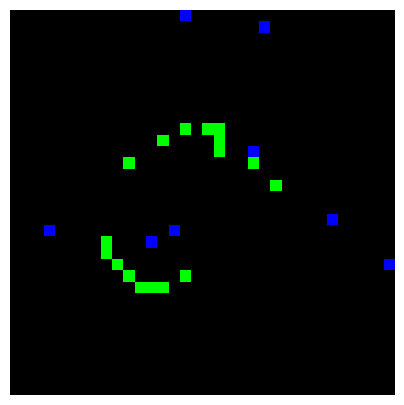

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [14]:
nmnist = tonic.datasets.NMNIST(save_to='./data', train=False)

events, label = nmnist[0]
transform = tonic.transforms.ToFrame(
    sensor_size=nmnist.sensor_size,
    time_window=10000,
)
frames = transform(events)
animation = tonic.utils.plot_animation(frames)

# Display the animation inline in a Jupyter notebook
from IPython.display import HTML
HTML(animation.to_jshtml())

During this task, we'll not train the network. We'll use already pretrained model (from UPeL course site). Use following line to upload `snn.pth` file, and then run cells with the SNN definition and loading of the weights.

In [ ]:
# from google.colab import files
# files.upload()

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    )

testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=False)
testloader = DataLoader(testset, batch_size=1, collate_fn=tonic.collation.PadTensors(batch_first=False))
net.load_state_dict(torch.load("snn.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Now, let's study the output of the SNN. As we already now, the output is in spiking format as well. We remember that for CNNs the output for MNIST classification is a 10-value vector, where each value refers to the probability that the object belongs to a particular class.

For SNNs we have a 10-value vector as well, but each can only be active or inactive (1 or 0). So how can we tell to which class do the objects belong? We just count the number of spikes registered for each class!

In the following code, we take a sample from dataset,  perform the forward-pass and visualize the output. Study it!

The target label is: tensor([0])


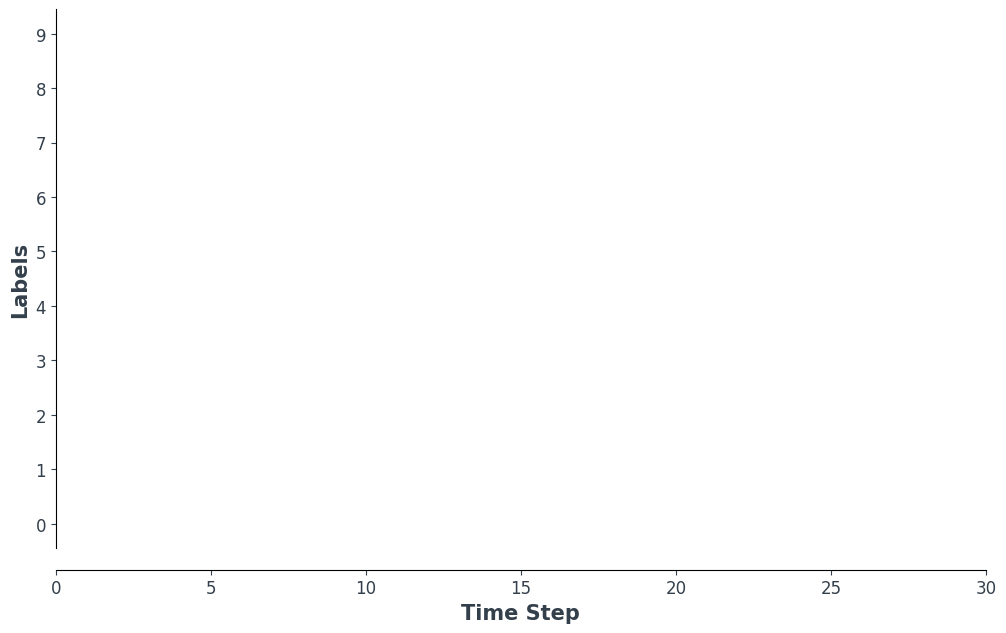

In [19]:
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

event_tensor, target = next(iter(testloader))
spk_rec = forward_pass(net, event_tensor)
idx = 0
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {target}")
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=5)
HTML(anim.to_html5_video())

That's it! There was not much for you to do in this part of the class. The teacher will ask you few questions about SNNs just to verify that you got the general idea :)